# Example 6 (Acme Tool Company data)

This example is similar to Example 5 but the initial value for $\hat{Y}_1$
is computed from the average of future data when $k = {1, 2, 3, 4, 5, 6}$

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc_stats

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})


## Function declarations

### Read `ods` to `DataFrame`


In [3]:
def read_ods(filename, columns):
  key_arr = (k for k in columns.keys())
  df = pd.read_excel(filename, engine="odf", header=0,
                     usecols=columns)
  df = df.rename(columns=columns)
  return df


### Get accuracy measures

In [4]:
def get_accuracy_measures(dataframe, columns=["Y_t", "hat_Y_t"]):
  Y_t = dataframe[columns[0]]
  hat_Y_t = dataframe[columns[1]]

  MAPE = (((Y_t - hat_Y_t).abs())/Y_t.abs()).mean()
  MAD = (Y_t - hat_Y_t).abs().mean()
  MSD = ((Y_t - hat_Y_t)**2).mean()
  
  return MAPE, MAD, MSD

  

### Standard error of autocorrelation


In [12]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)


### Compute `r_k`, `t_test`, and `LBQ`

In [13]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result

### Plot of autocorrelation function

In [14]:
def plot_autocorr_func(df_acorr_analysis, title=None):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title(f"Autocorrelation Function for {title}\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)


## Load the data

In [15]:
filename = "03-table-01-sales-of-saws-for-acme-tool.ods"
df = read_ods(filename, 
  {"t": "t", 
   "Sales": "Y_t"})

# add one additional row at the end of dataframe
# df.loc[len(df)] = [16, np.NaN]
num_of_quarters = 24
df_compute = df[:num_of_quarters]
df_test = df[num_of_quarters:]

df_compute

,t,Y_t
0,1,500
1,2,350
2,3,250
3,4,400
4,5,450
5,6,350
6,7,200
7,8,300
8,9,350
9,10,200


In [16]:
df_test

,t,Y_t
24,25,850
25,26,600
26,27,450
27,28,700


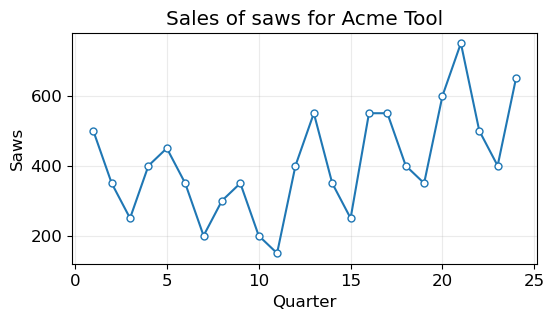

In [17]:
fig, ax = plt.subplots(figsize=(6, 3))

# exclude the last row
ax.plot(df_compute["t"], df_compute["Y_t"], marker='o', markersize=5, 
  markerfacecolor="white")
ax.set_xlabel("Quarter")
ax.set_ylabel("Saws")
ax.set_title("Sales of saws for Acme Tool")
ax.grid("on")
plt.show(fig)


## Forecasting (exponential smoothed values)

We set that 
$$\hat{Y}_1 = \frac{1}{k} \sum^k_{t=1} Y_t$$

In [18]:
df_forecast = df_compute.copy()

# Append the first row with Y_1 to correct the initial data
# for hat_Y_t
init_hat_Y_t = (df_forecast["Y_t"][:6]).mean()
data = []
data.insert(0, {"Y_t": init_hat_Y_t})
df_forecast = pd.concat([pd.DataFrame(data), df_forecast], ignore_index=True)

alpha = 0.1 
forecast_key = f"hat_Y_t_alpha_{alpha:.1f}"
residual_key = f"e_t_alpha_{alpha:.1f}"
df_forecast[forecast_key] = df_forecast["Y_t"].ewm(alpha=alpha, adjust=False).mean().shift(1)
df_forecast[residual_key] = df_forecast["Y_t"] - df_forecast[forecast_key]

alpha = 0.6 
forecast_key = f"hat_Y_t_alpha_{alpha:.1f}"
residual_key = f"e_t_alpha_{alpha:.1f}"
df_forecast[forecast_key] = df_forecast["Y_t"].ewm(alpha=alpha, adjust=False).mean().shift(1)
df_forecast[residual_key] = df_forecast["Y_t"] - df_forecast[forecast_key]

df_forecast = df_forecast.drop([0]).reset_index(drop=True)

df_forecast


,Y_t,t,hat_Y_t_alpha_0.1,e_t_alpha_0.1,hat_Y_t_alpha_0.6,e_t_alpha_0.6
0,500.0,1.0,383.333333,116.666667,383.333333,116.666667
1,350.0,2.0,395.000000,-45.000000,453.333333,-103.333333
2,250.0,3.0,390.500000,-140.500000,391.333333,-141.333333
3,400.0,4.0,376.450000,23.550000,306.533333,93.466667
4,450.0,5.0,378.805000,71.195000,362.613333,87.386667
5,350.0,6.0,385.924500,-35.924500,415.045333,-65.045333
6,200.0,7.0,382.332050,-182.332050,376.018133,-176.018133
7,300.0,8.0,364.098845,-64.098845,270.407253,29.592747
8,350.0,9.0,357.688961,-7.688961,288.162901,61.837099
9,200.0,10.0,356.920064,-156.920064,325.265161,-125.265161


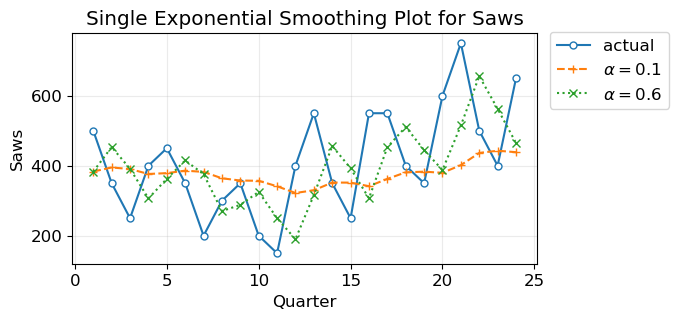

In [19]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_forecast["t"], df_forecast["Y_t"], 
  marker='o', markersize=5, markerfacecolor='white',
  label="actual")

alpha = 0.1
forecast_key = f"hat_Y_t_alpha_{alpha:.1f}"
ax.plot(df_forecast["t"], df_forecast[forecast_key], 
  marker='+', markersize=6, linestyle='--', 
  label=r"$\alpha = $"+f"{alpha}")

alpha = 0.6
forecast_key = f"hat_Y_t_alpha_{alpha:.1f}"
ax.plot(df_forecast["t"], df_forecast[forecast_key],
  marker='x', markersize=6, linestyle=':', 
  label=r"$\alpha = $"+f"{alpha}")

ax.set_xlabel("Quarter")
ax.set_ylabel("Saws")
ax.set_title("Single Exponential Smoothing Plot for Saws")
ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)


### Accuracy measures

In [20]:
alpha = 0.1
forecast_key = f"hat_Y_t_alpha_{alpha:.1f}"
MAPE, _ , MSE = get_accuracy_measures(df_forecast, columns=["Y_t", forecast_key])
print(f"alpha = {alpha}")
print(f"  MSE   {MSE:>9,.0f} ")
print(f"  MAPE    {MAPE*100:>9.1f}%")

alpha = 0.6
forecast_key = f"hat_Y_t_alpha_{alpha:.1f}"
MAPE, _ , MSE = get_accuracy_measures(df_forecast, columns=["Y_t", forecast_key])
print(f"alpha = {alpha}")
print(f"  MSE   {MSE:>9,.0f} ")
print(f"  MAPE    {MAPE*100:>9.1f}%")

alpha = 0.1
  MSE      21,091 
  MAPE         32.1%
alpha = 0.6
  MSE      22,153 
  MAPE         36.7%


#### Autocorrelation function for exponential smoothing residuals ($\alpha$ = 0.1)

In [23]:
num_of_rk = 6 
alpha = 0.1
residual_key = f"e_t_alpha_{alpha:.1f}"
df_moveave = df_forecast.copy()
df_moveave = df_moveave.dropna().reset_index(drop=True)
df_acorr_analysis = get_correlogram(df_moveave, num_of_rk, columns=['t', residual_key])
df_acorr_analysis


,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.279093,1.367273,2.113275,-0.422263,0.422263
1,2,-0.287017,-1.307900,4.449837,-0.453964,0.453964
2,3,0.246254,1.049813,6.251738,-0.485243,0.485243
3,4,0.616302,2.514450,18.102383,-0.507037,0.507037
4,5,0.054706,0.180627,18.200670,-0.626528,0.626528
5,6,-0.381935,-1.259355,23.257654,-0.627379,0.627379


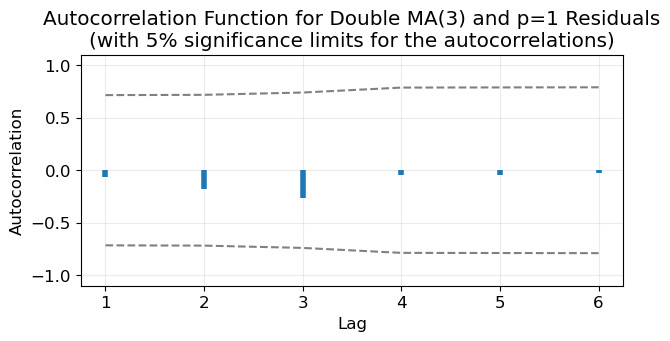

In [ ]:
plot_autocorr_func(df_acorr_analysis, title="Double MA(3) and p=1 Residuals")

#### Autocorrelation function for exponential smoothed residuals ($\alpha = 0.6$)

In [24]:
num_of_rk = 6 
alpha = 0.6
residual_key = f"e_t_alpha_{alpha:.1f}"
df_moveave = df_forecast.copy()
df_moveave = df_moveave.dropna().reset_index(drop=True)
df_acorr_analysis = get_correlogram(df_moveave, num_of_rk, columns=['t', residual_key])
df_acorr_analysis


,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,-0.000488,-0.002391,0.000006,-0.422263,0.422263
1,2,-0.785133,-3.846351,17.484326,-0.422263,0.422263
2,3,0.049279,0.161561,17.556485,-0.630979,0.630979
3,4,0.692650,2.268381,32.525122,-0.631664,0.631664
4,5,-0.035883,-0.098313,32.567409,-0.755043,0.755043
5,6,-0.641146,-1.755897,46.817758,-0.755347,0.755347


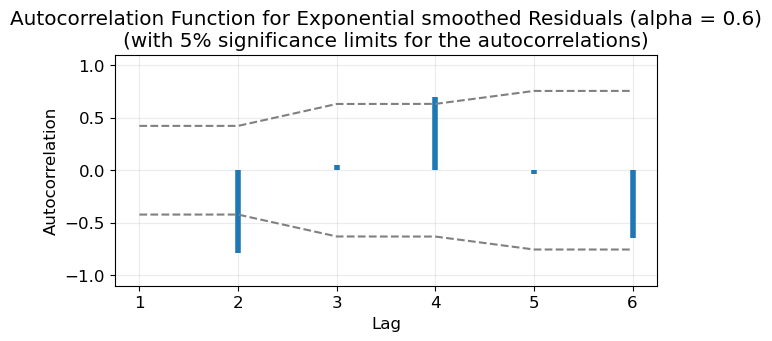

In [25]:
plot_autocorr_func(df_acorr_analysis, title=f"Exponential smoothed Residuals (alpha = {alpha})")